In [ ]:
!pip install nltk numpy openpyxl Pillow pyparsing scikit-learn scipy tqdm keras scipy tensorflow transformers

     |████████████████████████████████| 2.1MB 12.3MB/s 
     |████████████████████████████████| 3.3MB 30.0MB/s 
     |████████████████████████████████| 901kB 59.4MB/s 


In [ ]:
import nltk
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import re
from openpyxl import load_workbook
from sklearn import preprocessing
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
contractions = [
    (r"won\'t", "will not"),
    (r"can\'t", "cannot"),
    (r"i\'m", "i am"),
    (r"ain\'t", "is not"),
    (r"(\w+)\'ll", "\g<1> will"),
    (r"(\w+)n\'t", "\g<1> not"),
    (r"(\w+)\'ve", "\g<1> have"),
    (r"(\w+)\'s", "\g<1> is"),
    (r"(\w+)\'re", "\g<1> are"),
    (r"(\w+)\'d", "\g<1> would")
]


class Expander(object):
    def __init__(self, patterns=contractions):
        self.patterns = [(re.compile(regex, re.IGNORECASE), repl) for (regex, repl) in patterns]

    def expand(self, text):
        s = text
        for (pattern, repl) in self.patterns:
            s = re.sub(pattern, repl, s)
        return s

In [ ]:
ALL_CLASSES = [
    "content discussion", "greeting", "logistics", "assignment instructions", "instruction question",
    "assignment question", "general comment", "response", "incomplete/typo", "feedback",
    "emoticon/non-verbal", "discussion wrap-up", "outside material", "opening statement",
    "general question", "content question", "general discussion"
]
DATASET_PATH = "data/dataset.xlsx"

# Opens a single sheet for reading, returns a list of messages and a list of classes
def read_worksheet(filename, sheet_name, all_classes, label_encoder, no_columns):
    wb = load_workbook(filename, read_only=True)
    ws = wb[sheet_name]
    column_labels = next(ws.rows)
    X = []
    y = []
    for row in ws.rows:
        if row[0].value is None:
            break
        elif row[0].value.strip() == "Course":  # Skip the first line which only contains column titles
            continue
        new_entry = {}
        for i in range(no_columns):
            new_entry[column_labels[i].value.lower().replace(" ", "_")] = str(row[i].value)
        c_list = [new_entry["codepreliminary"].lower().strip()]
        if c_list[0] not in all_classes:
            c_list = new_entry["codepreliminary"].lower().strip().split("/")
        # If there are 2 classes listed in document add message twice (1 for each class)
        for c in c_list:
            new_entry["codepreliminary"] = label_encoder.transform([c])[0]
            X.append(new_entry["message"])
            y.append(label_encoder.transform([c])[0])
    wb.close()
    return X, y

le = preprocessing.LabelEncoder()
le.fit(ALL_CLASSES)

LabelEncoder()

In [ ]:
def preprocess_data(dataset, classes):
    # List of emojis found in messages
    emojis = [":)", ":(", ":D", "👍"]
    ps = PorterStemmer()
    tkn = TweetTokenizer()  # Use tweet tokenizer to not split emojis as punctuation
    exp = Expander()  # Expands contractions such as I'm, he's into I am, he is
    new_dataset = []
    new_classes = []
    stopword_set = stopwords.words("english")
    for i, entry in enumerate(dataset):
        exp.expand(entry)
        new_entry = []
        # Remove capitalization, stopwords
        for token in tkn.tokenize(entry):
            new_token = ps.stem(token)  # Stem the token and convert to lowercase
            if new_token.startswith("http"):
                new_token = "url"  # Replace links with a url tag
            if any(emoji in new_token for emoji in emojis):
                new_token = "emoji"  # Replace emojis with a string
            if (new_token not in stopword_set or len(new_token) == 1) and new_token.isalnum():
                new_entry.append(new_token)
        if len(new_entry) > 0:
            new_dataset.append(" ".join(new_entry))
            new_classes.append(classes[i])

    return new_dataset, new_classes

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
X, y = read_worksheet(DATASET_PATH, "Discussion only data", ALL_CLASSES, le, 10)
X2, y2 = read_worksheet(DATASET_PATH, "CREW data", ALL_CLASSES, le, 11)
X.extend(X2)  # Join worksheets into a single dataset
y.extend(y2)

#X, y = preprocess_data(X, y)
X = np.array(X) 
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

t = Tokenizer()
t.fit_on_texts(X_train)

X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

vocabulary_size = len(t.word_index) + 1

In [ ]:
# Model from labs with embedding
embedding_dim = 256

clear_session()
input_dim = X_train.shape[1]
model = Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_dim, input_length=500))
model.add(layers.Flatten())
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(len(ALL_CLASSES), activation="sigmoid"))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128)
scores = model.evaluate(X_test, y_test)

Epoch 1/20
6/6 [==============================] - 4s 653ms/step - loss: 5.1607 - accuracy: 0.2443 - val_loss: 2.2790 - val_accuracy: 0.4438
Epoch 2/20
6/6 [==============================] - 4s 763ms/step - loss: 2.0703 - accuracy: 0.4714 - val_loss: 2.0661 - val_accuracy: 0.4438
Epoch 3/20
6/6 [==============================] - 4s 710ms/step - loss: 1.7839 - accuracy: 0.5058 - val_loss: 1.9008 - val_accuracy: 0.4852
Epoch 4/20
6/6 [==============================] - 5s 837ms/step - loss: 1.6715 - accuracy: 0.5317 - val_loss: 1.8605 - val_accuracy: 0.5030
Epoch 5/20
6/6 [==============================] - 5s 838ms/step - loss: 1.6350 - accuracy: 0.5358 - val_loss: 1.8148 - val_accuracy: 0.4911
Epoch 6/20
6/6 [==============================] - 5s 835ms/step - loss: 1.5625 - accuracy: 0.5628 - val_loss: 1.7598 - val_accuracy: 0.4970
Epoch 7/20
6/6 [==============================] - 5s 900ms/step - loss: 1.4681 - accuracy: 0.5777 - val_loss: 1.7680 - val_accuracy: 0.5148
Epoch 8/20
6/6 [====

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8991
Testing Accuracy:  0.5740


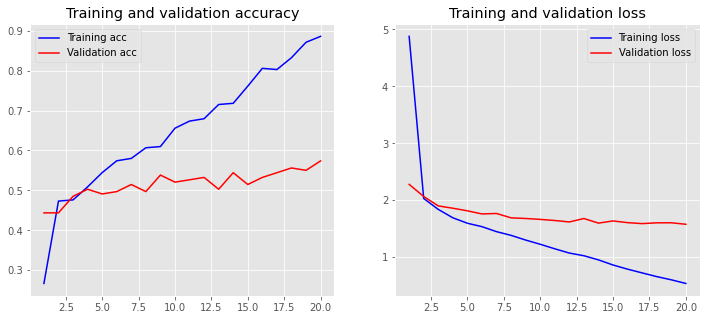

In [ ]:
plot_history(history)

In [ ]:
# K Fold validation with different model (no embeddings)
from sklearn.model_selection import KFold

no_folds = 5
kfold = KFold(no_folds, shuffle=True)

# Convert to numpy arrays so indexing with list of indexes works
X = np.array(X) 
y = np.array(y)

test_accuracy_log = []

counter = 1
for train, test in kfold.split(X, y):
  X_train = X[train]
  y_train = y[train]
  X_test = X[test]
  y_test = y[test]

  tokenizer = Tokenizer(5000)
  tokenizer.fit_on_texts(X_train)
  X_train = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(X_train), mode="tfidf")
  X_test = tokenizer.sequences_to_matrix(tokenizer.texts_to_sequences(X_test), mode="tfidf")
  y_train = to_categorical(y_train, len(ALL_CLASSES))
  y_test = to_categorical(y_test, len(ALL_CLASSES))

  clear_session()
  model = Sequential()
  model.add(layers.Dense(512, input_shape=(5000,)))
  model.add(layers.Activation("relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(len(ALL_CLASSES)))
  model.add(layers.Activation("softmax"))
  model.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])
  print("------------------------------------------------------------------------")
  print("Step number {}".format(counter))
  history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=128, verbose=0)
  score = model.evaluate(X_test, y_test, verbose=0)
  print("Results for fold {}\n\tTest accuracy: {:.4f}\n\tTest loss: {:.4f}".format(counter, score[1], score[0]))
  test_accuracy_log.append(score[1])
  counter += 1  

print("Average accuracy: {:.4f}".format(sum(test_accuracy_log) / len(test_accuracy_log)))

------------------------------------------------------------------------
Step number 1
Results for fold 1
	Test accuracy: 0.6190
	Test loss: 1.7837
------------------------------------------------------------------------
Step number 2
Results for fold 2
	Test accuracy: 0.6726
	Test loss: 1.3869
------------------------------------------------------------------------
Step number 3
Results for fold 3
	Test accuracy: 0.5749
	Test loss: 2.0118
------------------------------------------------------------------------
Step number 4
Results for fold 4
	Test accuracy: 0.6168
	Test loss: 1.6629
------------------------------------------------------------------------
Step number 5
Results for fold 5
	Test accuracy: 0.6587
	Test loss: 1.4963
Average accuracy: 0.6284
